Tugas Besar Nisa Hanum Harani
Sentimen Vaksin

In [1]:
!pip install elang

     |████████████████████████████████| 342 kB 15.5 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow import keras 

In [4]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model, Model
from keras.layers import Activation, Dense, Dropout, Embedding, LSTM
from keras import utils
from tensorflow.keras.optimizers import RMSprop

# Word2vec
import gensim
from gensim.models import Word2Vec

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import html
import string as str
from elang.plot.utils import plot2d, plotNeighbours

# Widget
from ipywidgets import widgets

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Kominfo/data vaksin/data olah/datavaxlama.csv', sep=';')

In [6]:
df.head(20)

,pesan,label
0,thank you dbctssi and aventus aventus filo,positif
1,staf kami sentiasa mementingkan aspek kebersih...,positif
2,lengkap sudah dua dosis vaksin astra zeneca di...,positif
3,lengkap sudah dua dosis vaksin astra zeneca di...,positif
4,vaksin pfizer tanggal sept jam habis maghrib m...,negatif
5,selesai,netral
6,masih raguragu sama ada anda perlu ambil vaksi...,negatif
7,tak mintak banyak cameron highland pun jadi la...,negatif
8,makubaliano ya chanjo kati ya eu nya,negatif
9,enggak paham juga kenapa jadwalnya bisa beda v...,positif


Membagi Data

In [7]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

train_percentage = df_train['label'].value_counts(normalize=True)*100

test_percentage  = df_test['label'].value_counts(normalize=True)*100

print('TRAIN DATASET')
print('Train size:', len(df_train))
print('Persentase Train Dataset:')
print(round(train_percentage, 2))

print('=================================================================')

print('TEST DATASET')
print('Test size:', len(df_test))
print('Persentase Test Dataset:')
print(round(test_percentage, 2))

TRAIN DATASET
Train size: 309
Persentase Train Dataset:
netral     53.07
positif    29.77
negatif    17.15
Name: label, dtype: float64
TEST DATASET
Test size: 78
Persentase Test Dataset:
netral     52.56
positif    29.49
negatif    17.95
Name: label, dtype: float64


In [8]:
%%time
w2v_model = Word2Vec.load('/content/drive/MyDrive/Kominfo/Tugas Besar/model/300/idwiki_word2vec_300.w2v')

CPU times: user 1.28 s, sys: 301 ms, total: 1.58 s
Wall time: 14.5 s


In [9]:
%%time
words = w2v_model.wv.vocab.keys()
vocab_size_w2v = len(words)
print("Vocab size", vocab_size_w2v)

Vocab size 234482
CPU times: user 721 µs, sys: 0 ns, total: 721 µs
Wall time: 725 µs


In [10]:
w2v_model.most_similar("vaksin")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('vaksinasi', 0.6263900399208069),
 ('antibiotik', 0.6013439893722534),
 ('antibodi', 0.5786682963371277),
 ('virus', 0.5475364923477173),
 ('obat', 0.5360382199287415),
 ('polio', 0.5358050465583801),
 ('imunisasi', 0.5329275131225586),
 ('dapson', 0.5110607147216797),
 ('azt', 0.5082553625106812),
 ('influenza', 0.5057495832443237)]

Word Embedding

In [11]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.pesan)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 1216
CPU times: user 19.4 ms, sys: 0 ns, total: 19.4 ms
Wall time: 20.4 ms


In [12]:
%%time
max_input = 55

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.pesan), maxlen=max_input)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.pesan), maxlen=max_input)

print('Shape of x_train tensor:', x_train.shape)
print('Shape of x_test tensor:', x_test.shape)

Shape of x_train tensor: (309, 55)
Shape of x_test tensor: (78, 55)
CPU times: user 7.72 ms, sys: 0 ns, total: 7.72 ms
Wall time: 7.73 ms


Label Encoder

In [13]:
labels = df_train.label.unique().tolist()
labels

['netral', 'positif', 'negatif']

In [14]:
encoder = LabelEncoder()
encoder.fit(df_test.label.tolist())

y_train = encoder.transform(df_train.label.tolist())
y_test = encoder.transform(df_test.label.tolist())

Embedding layer

In [15]:
embed_dim = 300

embedding_matrix = np.zeros((vocab_size, embed_dim))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(1216, 300)


In [16]:
embedding_layer = Embedding(vocab_size, embed_dim, weights=[embedding_matrix], input_length=max_input, trainable=False)

Membuat Model

In [17]:
%%time

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(128, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 55, 300)           364800    
_________________________________________________________________
dropout (Dropout)            (None, 55, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 584,577
Trainable params: 219,777
Non-trainable params: 364,800
_________________________________________________________________
CPU times: user 269 ms, sys: 19.9 ms, total: 289 ms
Wall time: 450 ms


Compile model

In [18]:
opt = RMSprop(learning_rate=0.0001)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['acc'])

Training Model

In [19]:
%%time

hist_1 = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=80,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/80
2/2 [==============================] - 2s 489ms/step - loss: 0.5495 - acc: 0.3927 - val_loss: 0.4212 - val_acc: 0.5968
Epoch 2/80
2/2 [==============================] - 0s 107ms/step - loss: 0.5363 - acc: 0.4453 - val_loss: 0.3695 - val_acc: 0.5806
Epoch 3/80
2/2 [==============================] - 0s 109ms/step - loss: 0.5164 - acc: 0.4251 - val_loss: 0.3314 - val_acc: 0.5968
Epoch 4/80
2/2 [==============================] - 0s 94ms/step - loss: 0.4585 - acc: 0.4372 - val_loss: 0.3106 - val_acc: 0.6129
Epoch 5/80
2/2 [==============================] - 0s 102ms/step - loss: 0.4570 - acc: 0.4737 - val_loss: 0.2802 - val_acc: 0.6129
Epoch 6/80
2/2 [==============================] - 0s 106ms/step - loss: 0.4149 - acc: 0.4575 - val_loss: 0.2505 - val_acc: 0.6129
Epoch 7/80
2/2 [==============================] - 0s 98ms/step - loss: 0.3765 - acc: 0.4939 - val_loss: 0.2263 - val_acc: 0.6129
Epoch 8/80
2/2 [==============================] - 0s 95ms/step - loss: 0.3800 - acc: 0.4696 

**Evaluate Model**

In [20]:
%%time
# Find train and test accuracy
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
                                    

Training Accuracy: 0.5307
Testing Accuracy:  0.5256
CPU times: user 520 ms, sys: 44.4 ms, total: 564 ms
Wall time: 360 ms


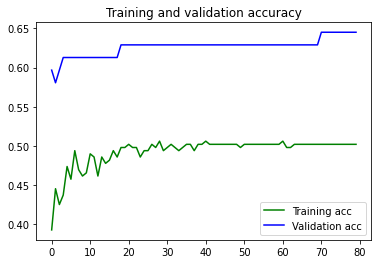

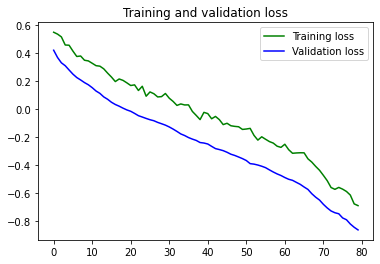

In [21]:
# Plot train/test loss and accuracy
acc = hist_1.history['acc']
val_acc = hist_1.history['val_acc']
loss = hist_1.history['loss']
val_loss = hist_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Predict**

In [22]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [23]:
# Get predicted values
y_pred = model.predict(x_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(x_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

In [24]:
# Convert y_test to 1d numpy array
y_test_array = np.zeros(x_test.shape[0])

# Find class with 1
for i in range(0, y_test.shape[0]):
    label_predict = np.argmax(y_test[i])
    y_test_array[i] = label_predict

y_test_array = y_test_array.astype(int)

In [25]:
class_names = np.array(['Negative', 'Neutral', 'Positive'])

Confusion matrix, without normalization
[[78]]
Normalized confusion matrix
[[1.]]


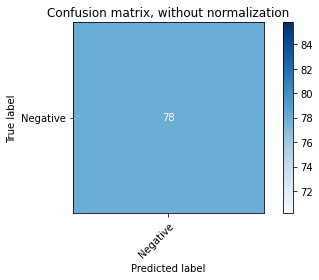

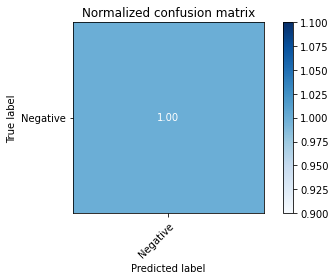

In [26]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=1)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [27]:
def preprocess(text):
    review=re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',' ',text)
    review=review.lower()
    review=review.split()
    review=[word for word in review if not word in stop_words]
    print(review)
    review=pad_sequences(tokenizer.texts_to_sequences([review]), maxlen=300)
    return review

In [28]:
def prediction(score):
    #review=preprocess(review)
    #score=model.predict(review)
    if score < 0.4:
        print("Negative")
    elif score > 0.4 and score<0.6:
        print("Neutral")
    else:
        print("Positive")
    print(score)

In [29]:
def predict(text):
    start_at = time.time()
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_input)
    score = model.predict([x_test])[0]
    label = prediction(score)

    # return {"label": label, "score": float(score),
    #    "elapsed_time": time.time()-start_at}  
    
    return label

In [30]:
predict("semoga vaksin dapat meningkatkan imun")

Positive
[1.]


**Confusion Matrix**

Pelatihan

In [32]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.label)
scores = model.predict(x_test, verbose=1)
# scores = model.predict(x_test, verbose=1, batch_size=BATCH_SIZE)
y_pred_1d = [prediction(score) for score in scores]

3/3 [==============================] - 0s 21ms/step
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[1.]
Positive
[

**Classification Report**

In [33]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

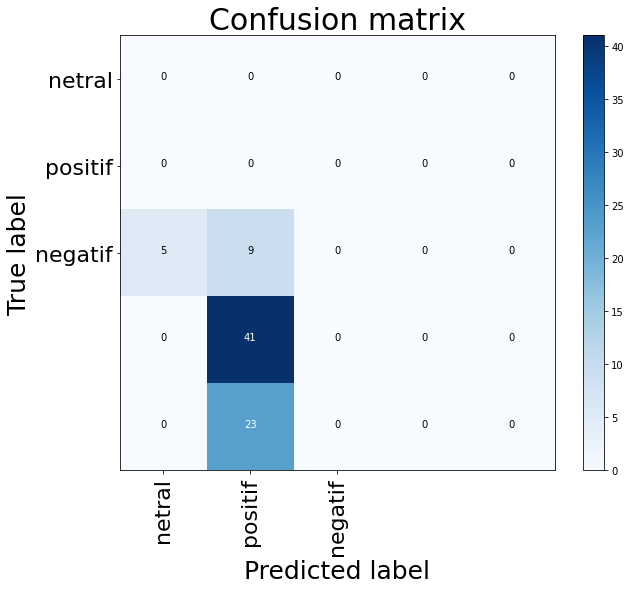

CPU times: user 314 ms, sys: 10.1 ms, total: 324 ms
Wall time: 314 ms


In [116]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=df_train.label.unique(), title="Confusion matrix")
plt.show()

In [117]:
recall = recall_score(y_test_1d, y_pred_1d, average='macro')
print("Recall Uji:", round(recall, 2))

print('======================================================')

recall = recall_score(y_train_2d, y_pred_2d, average='macro')
print("Recall Latih:", round(recall, 2))

Recall Uji: 0.0
Recall Latih: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Save Model**

In [35]:
from keras.models import load_model 
model.save('/content/drive/MyDrive/Kominfo/data vaksin/program/model/model.h5')
w2v_model.save('/content/drive/MyDrive/Kominfo/data vaksin/program/model/model.w2v')
import pickle
pickle.dump(tokenizer, open('/content/drive/MyDrive/Kominfo/data vaksin/program/model/tokenizer.pkl','wb'),protocol=0)
pickle.dump(encoder, open('/content/drive/MyDrive/Kominfo/data vaksin/program/model/encoder.pkl','wb'),protocol=0)
